## Interpolation Test Stimuli Performance
Test set 1: Linear Interpolation. 

Two subjects are tested on linearly interpolated shuffle gaps. Here is what I need:
- Load in data and remove debug trials. 
- For each test trial, examine if the previous 64 training trials had over 80% accuracy. 
    - 4 training stimuli, means on average >13/16 of each stimuli
- Combined, individuals
    - Psychometric Functions

### Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from behav import plotting, utils, loading

import seaborn as sns
sns.set_style("whitegrid")

data_path = '/mnt/cube/RawData/Magpi/'

subjects = (
    ['B1520', 'B1535']
)

In [2]:
%%time
behav_data = loading.load_data_pandas(subjects, data_path)

CPU times: user 1.18 s, sys: 54.9 ms, total: 1.23 s
Wall time: 1.34 s


### Clean out debug trials before shaping

In [3]:
behav_data['B1520'] = behav_data['B1520'][behav_data['B1520'].index > '2023-01-19 00:00:00.000000'] 
## B1520 started trials on the 19th, previous are debug trials

In [4]:
behav_data['B1535'] = behav_data['B1535'][behav_data['B1535'].index > '2023-01-20 00:00:00.000000'] 
## B1535 started trials on the 20th, previous are debug trials

### For every test trial, only keep if the previous 64 trial accuracy is > 0.8

In [8]:
import pandas as pd
from tqdm.autonotebook import tqdm

In [9]:
max_trials = 64
accuracy_threshold = 0.8

In [32]:
%%time
test_data = {}
## for each subject
for subj in subjects:
    numbered_trials = behav_data[subj].reset_index()
    test_trials = numbered_trials[numbered_trials.type_ == 'test']
    valid_trials = pd.DataFrame(columns = test_trials.columns)
    ## iterative through each test trial
    for i, row in tqdm(test_trials.iterrows()):
        training_trials = []
        pointer = i
        ## while training trials are not fully collected
        while len(training_trials) < max_trials:
            ## go to previous trial to the pointer
            pointer = pointer - 1
            pointed_trial = numbered_trials.loc[pointer]
            ## if the pointer is on a normal trial, append to training_trials
            if pointed_trial.type_ == 'normal':
                training_trials.append(pointed_trial)
        
        ## check if training trials exceed criteria
        training_trials = pd.concat(training_trials)
        training_accuracy = np.mean(training_trials.correct)
        if training_accuracy > 0.8:
            valid_trials = pd.concat([valid_trials, pd.DataFrame([row], columns = test_trials.columns)], ignore_index = False)
    
    test_data[subj] = valid_trials

1192it [00:40, 29.20it/s]
70it [00:01, 41.38it/s]


In [36]:
## For every test trial, parse relevant info
for subj in subjects:
    
    stim_types = []
    pair_indices = []
    inter_nums = []

    for i, row in test_data[subj].iterrows():
        parsed = row.stimulus.split('_')
        stim_types.append(parsed[2])
        pair_indices.append(parsed[3])
        inter_nums.append(int(parsed[4].split('.')[0]))

    test_data[subj]['stim_type'] = stim_types
    test_data[subj]['pair_indices'] = pair_indices
    test_data[subj]['inter_nums'] = inter_nums

## Plot psychometric function

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
PMFX = {}
for subj in subjects:
    test_proportion = pd.DataFrame(test_data[subj].groupby(
            ['stim_type', 'pair_indices', 'inter_nums']
        )['response'].agg('value_counts', normalize = True))
    test_proportion = test_proportion.rename(columns = {'response': 'prop'})
    PMFX[subj] = test_proportion

### Fit psychometric function

In [117]:
from scipy.optimize import curve_fit

In [145]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

In [153]:
## fit to sigmoid (bernoulli process from Marvin)
def bernoulli(x, A, B, K, M):
    p = A + ((K - A) / (1 + np.exp(-B*(x - M))))
    return y

## Plot

In [1]:
subject_list = []
stim_type_list = []
pair_index_list = []
response_type_list = []
x0_list = []
k_list = []
cov_list = []

## plotting
for subj in subjects:
    ## for each stim_type
    for stim_type in np.unique(test_data[subj].stim_type):
        ## for each pair index
        for pair_index in np.unique(test_data[subj].pair_indices):
            plt.figure(figsize = (16, 4))
            
            ## plot empirical accuracies
            sns.scatterplot(
                data = PMFX[subj].loc[stim_type, pair_index], 
                x = 'inter_nums', y = 'prop', hue = 'response', marker = "X"
            )
            
            ## fit and plot psychometric functions
            PMFX2 = PMFX[subj].reset_index()
            for response_type in np.unique(PMFX2.response):
                print("Generating psychometric curve for " + str(pair_index) + '_' + str(response_type))
                PMFX2_specific = PMFX2[(PMFX2.pair_indices == pair_index) & (PMFX2.response == response_type)]
                x = PMFX2_specific['inter_nums']
                y = PMFX2_specific['prop']
                try:
                    popt, pcov = curve_fit(sigmoid, x, y, p0 = [0, 1, 1, 1])

                    subject_list.append(subj)
                    stim_type_list.append(stim_type)
                    pair_index_list.append(pair_index)
                    response_type_list.append(response_type)
                    x0 = popt[0]
                    x0_list.append(x0)
                    k = popt[1]
                    k_list.append(k)
                    cov_list.append(pcov)
                    
                    y_sig = sigmoid(x, *popt)
                    line_col = 'green'
                    if response_type == 'left':
                        line_col = 'cornflowerblue'
                    if response_type == 'right':
                        line_col = 'orange'
                    sns.lineplot(x, y_sig, color = line_col, linewidth = 3)
                except Exception as e:
                    print(e)
            
            plt.xlabel('Interpolation # (0 = MaxMF, 128 = MinMF)')
            plt.ylabel('Proportion of Response')
            title = subj + '_' + stim_type + '_index:' + pair_index
            plt.title(title)
            
PMFX_results = pd.DataFrame(
    {
        "subject": subject_list,
        "stim_type": stim_type_list,
        "pair_index": pair_index_list,
        "response_type": response_type_list,
        "x0": x0_list,
        "k": k_list,
        "cov": cov_list
    }
)

NameError: name 'subjects' is not defined

In [164]:
PMFX_results

,subject,stim_type,pair_index,response_type,x0,k,cov
0,B1520,INTER,0,left,51.536951,-2.778040e-02,"[[25.49410414220667, -0.001498425317855592], [..."
1,B1520,INTER,0,none,1.000000,1.000000e+00,"[[inf, inf], [inf, inf]]"
2,B1520,INTER,0,right,52.491423,2.225381e-02,"[[42.79033926105735, 0.007092636695431627], [0..."
3,B1520,INTER,1,none,1.000000,-7.989149e+06,"[[inf, inf], [inf, inf]]"
4,B1520,INTER,1,right,-213.292959,-7.665163e+01,"[[inf, inf], [inf, inf]]"
5,B1535,INTER,0,left,-4.841345,4.740525e+00,"[[inf, inf], [inf, inf]]"
6,B1535,INTER,1,left,1.000000,1.053714e+00,"[[inf, inf], [inf, inf]]"


## Sample size

In [86]:
sample_size = {}
for subj in subjects:
    test_count = pd.DataFrame(test_data[subj].groupby(
            ['stim_type', 'pair_indices', 'inter_nums']
        )['response'].agg('count'))
    sample_size[subj] = test_count

In [90]:
sample_size['B1520']

response
stim_type pair_indices inter_nums          
INTER     0            0                 18
                       4                  5
                       8                  9
                       12                 6
                       16                12
...                                     ...
          1            108               12
                       112                9
                       116               11
                       120               12
                       124                5

[64 rows x 1 columns]

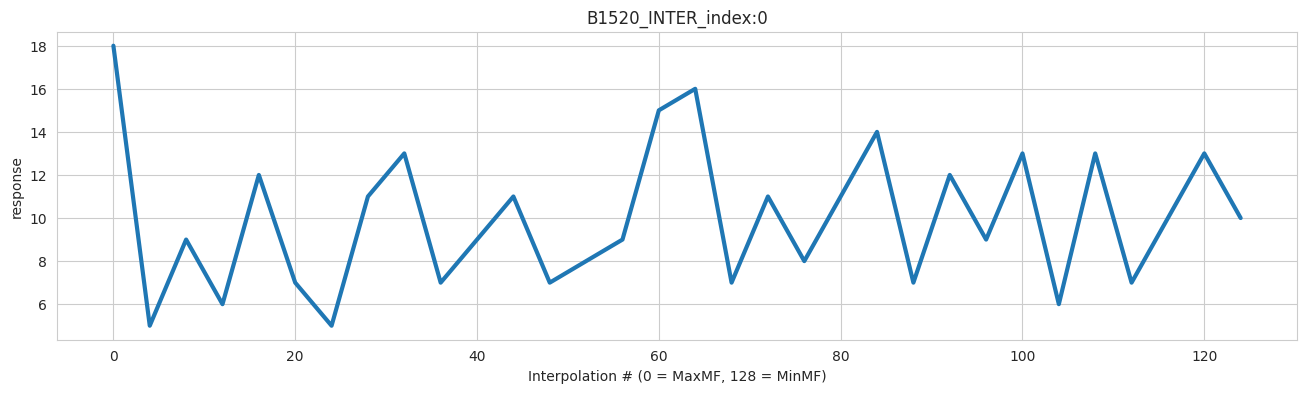

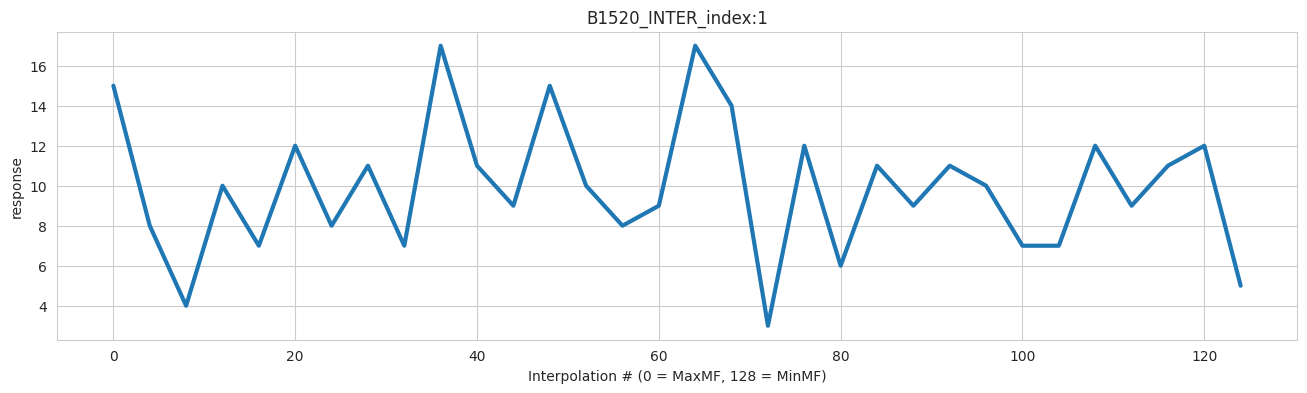

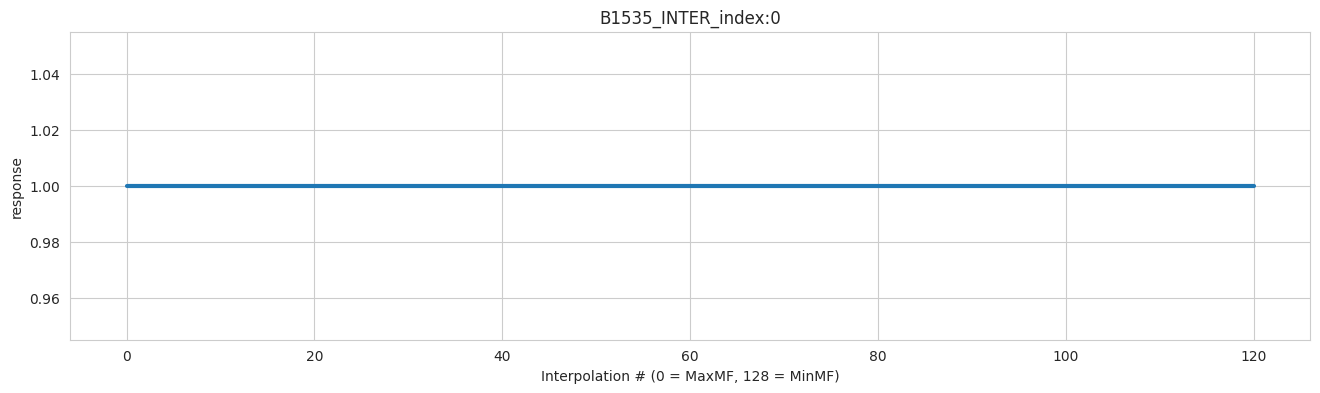

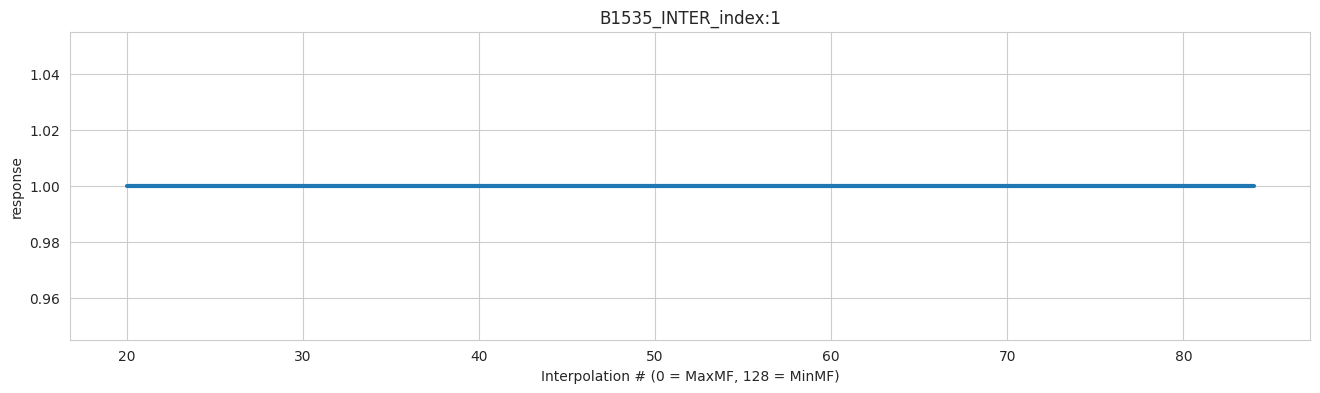

In [93]:
## plotting
for subj in subjects:
    ## for each stim_type
    for stim_type in np.unique(test_data[subj].stim_type):
        ## for each pair index
        for pair_index in np.unique(test_data[subj].pair_indices):
            plt.figure(figsize = (16, 4))
            sns.lineplot(
                data = sample_size[subj].loc[stim_type, pair_index], 
                x = 'inter_nums',
                y = 'response',
                linewidth = 3
            )
            plt.xlabel('Interpolation # (0 = MaxMF, 128 = MinMF)')
            title = subj + '_' + stim_type + '_index:' + pair_index
            plt.title(title)